In [1]:

library(tidyverse)
library(patchwork)
library(Seurat)
library(ggthemes)
library(ggpubr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject



In [20]:
source("/shareb/zliu//analysis/hires_gastrulation/CHARMtools/Rlibs/plotFun.R")

In [2]:
df_epi <- read_tsv("/shareb/zliu/analysis/hires_mouse_dev/figure3_related/pileup/processed/insulation/epiblast_and_PS.standardTAD.tsv")
df_neuron <- read_tsv("/shareb/zliu/analysis/hires_mouse_dev/figure3_related/pileup/processed/insulation/early_neurons.standardTAD.tsv")
df_mesenchyme <- read_tsv("/shareb/zliu/analysis/hires_mouse_dev/figure3_related/pileup/processed/insulation/mix_late_mesenchyme.standardTAD.tsv")

Rows: 136288 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): chrom, region
dbl (20): start, end, log2_insulation_score_100000, n_valid_pixels_100000, l...
lgl  (7): is_bad_bin, is_boundary_100000, is_boundary_200000, is_boundary_30...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 136288 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): chrom, region
dbl (20): start, end, log2_insulation_score_100000, n_valid_pixels_100000, l...
lgl  (7): is_bad_bin, is_boundary_100000, is_boundary_200000, is_boundary_30...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 136288 Columns: 29
── Column specification ─────────────────────────────

In [3]:
#基因名与位置
mm10genes <- read_tsv("/share/Data/public/ref_genome/mouse_ref/M23/raw_data/gene.bed",col_names = c("chrom","start","end","id","name","strand")) %>% 
    arrange(desc(end-start)) %>% group_by(name) %>% slice(1) %>% select("chrom","start","end","name") 


Rows: 55335 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chrom, id, name, strand
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
cbind(
df_epi %>% select(1:3,log2_insulation_score_500000,boundary_strength_500000) %>% 
rename(is500k_ct1 = log2_insulation_score_500000,bs500k_ct1 = boundary_strength_500000) ,
df_neuron %>% select(log2_insulation_score_500000,boundary_strength_500000) %>% 
rename(is500k_ct2 = log2_insulation_score_500000,bs500k_ct2 = boundary_strength_500000) ) -> compare_neu

cbind(
    df_epi %>% select(1:3,log2_insulation_score_500000,boundary_strength_500000) %>%
    rename(is500k_ct1 = log2_insulation_score_500000,bs500k_ct1 = boundary_strength_500000) ,
    df_mesenchyme %>% select(log2_insulation_score_500000,boundary_strength_500000) %>%
    rename(is500k_ct2 = log2_insulation_score_500000,bs500k_ct2 = boundary_strength_500000) ) -> compare_mes


compare_neu %>% mutate(diff = is500k_ct1 - is500k_ct2) %>% rowwise() %>%
     filter(abs(diff) > 0, !(is.na(bs500k_ct1) & is.na(bs500k_ct2))) %>% arrange(desc(abs(diff))) %>% 
     mutate(bs_diff = bs500k_ct1 - bs500k_ct2)  -> compare_neu
compare_mes %>% mutate(diff = is500k_ct1 - is500k_ct2) %>% rowwise() %>%
     filter(abs(diff) > 0, !(is.na(bs500k_ct1) & is.na(bs500k_ct2))) %>% arrange(desc(abs(diff))) %>% 
     mutate(bs_diff = bs500k_ct1 - bs500k_ct2)  -> compare_mes


In [5]:
compare_neu %>% filter(bs500k_ct1 > 0.5 | bs500k_ct2 > 0.5) %>% arrange(desc(diff)) %>% head(100) %>% mutate(btype="neu") -> neu_boundaries
compare_neu %>% filter(bs500k_ct1 > 0.5 | bs500k_ct2 > 0.5) %>% arrange(desc(diff)) %>% tail(100) %>% mutate(btype="epi") -> epin_boundaries

compare_mes %>% filter(bs500k_ct1 > 0.5 | bs500k_ct2 > 0.5) %>% arrange(desc(diff)) %>% head(100) %>% mutate(btype="mes") -> mes_boundaries
compare_mes %>% filter(bs500k_ct1 > 0.5 | bs500k_ct2 > 0.5) %>% arrange(desc(diff)) %>% tail(100) %>% mutate(btype="epi") -> epim_boundaries

In [6]:
# differiantial expression
hires <- readRDS("/shareb/zliu/analysis/hires_mouse_dev/hires_mouse_emb_dev.new.rds")
Idents(hires) <- hires$celltype
DefaultAssay(hires)<-"SCT"

diff_neu <- FindMarkers(hires,ident.1 = "early neurons",ident.2 = "epiblast and PS",logfc.threshold = 0)
diff_mes <- FindMarkers(hires,ident.1 = "mix late mesenchyme",ident.2 = "epiblast and PS",logfc.threshold = 0)

In [12]:
genes <- read_table("~/share/Data/public/ref_genome/mouse_ref/M23/raw_data/gene.bed",col_names = c("chr","start","end","id","name","strand")) %>% group_by(name) %>% slice(1)


── Column specification ────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double(),
  id = col_character(),
  name = col_character(),
  strand = col_character()
)



In [13]:
source("/shareb/zliu//analysis/hires_gastrulation/CHARMtools/Rlibs/compartment_ana.R")

meso_ecto_data <- getCpGDiffVocanoPlotData(hires,c("mix late mesenchyme"),c("epiblast and PS"),genes,1000000,slot_cpg = "cpg")
meso_ecto_plot <- plotCpGDiffVocanoPlot(meso_ecto_data,"MLM vs. Epi",text_x_Pos = -0.1,scale_factor = 1)
a <- meso_ecto_plot + theme_classic()+ ggtitle("") + xlab("scA/B difference") + ylab("-log10(P-value)")

meso_ecto_data <- getCpGDiffVocanoPlotData(hires,c("early neurons"),c("epiblast and PS"),genes,1000000,slot_cpg = "cpg")
meso_ecto_plot <- plotCpGDiffVocanoPlot(meso_ecto_data,"EN vs. Epi",text_x_Pos = -0.1,scale_factor = 1)
b <- meso_ecto_plot + theme_classic()+ ggtitle("") + xlab("scA/B difference") + ylab("-log10(P-value)")

Joining, by = c("chr", "pos")
Joining, by = "name"


[1] "mean difference of CpG of all gene is 0.0448687567154707"


Joining, by = c("chr", "pos")
Joining, by = "name"


[1] "mean difference of CpG of all gene is 0.0198958691362878"


In [ ]:
meso_ecto_plot + theme_classic()+ ggtitle("") + xlab("scA/B difference") + ylab("-log10(P-value)")

In [46]:
options(repr.plot.height=3,repr.plot.width = 6,repr.plot.res =200)
(a) %>% ggsave(filename = "MLM_EPI_scAB.svg",width = 3,height=3)
(b) %>% ggsave(filename = "EN_EPI_scAB.svg",width = 3,height=3)

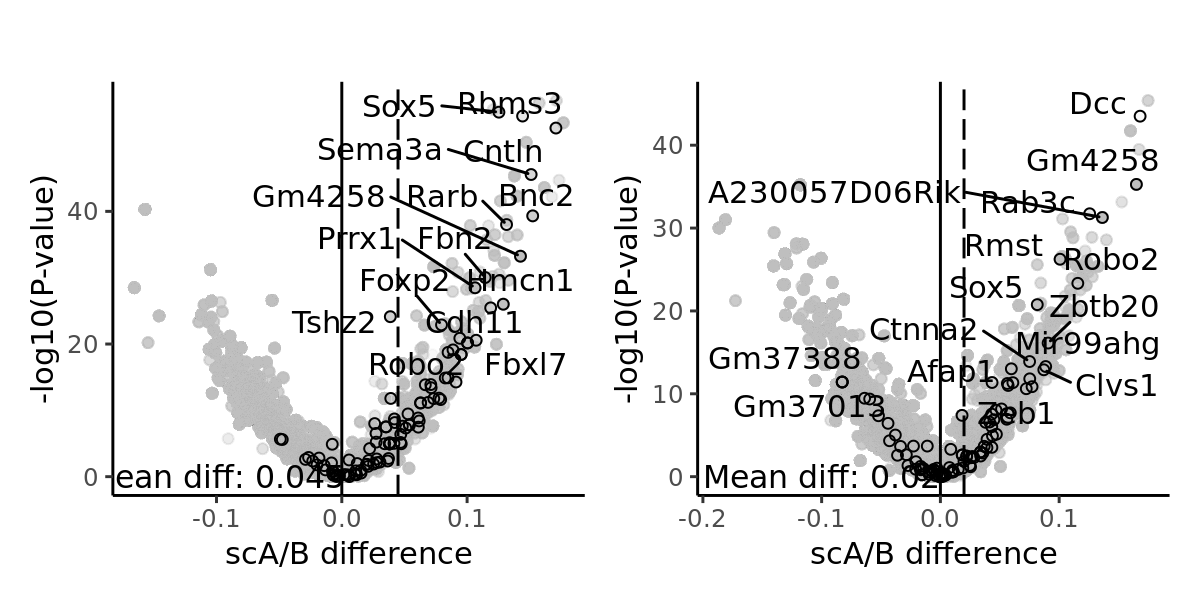

In [34]:
a|b

In [57]:
options(repr.plot.height=4,repr.plot.width = 4,repr.plot.res =200)
pdata <- rbind(neu_boundaries %>% select(1:3,diff,btype),epin_boundaries %>% select(1:3,diff,btype)) %>% ungroup() %>% #mutate(start = start - 20000,end = end+20000) %>% 
    valr::bed_intersect(mm10genes)%>% 
    rename(name = name.y) %>% left_join(diff_neu %>% rownames_to_column("name")) %>% na.omit() 
dim(pdata)
pdata %>% group_by(btype.x) %>% summarise(count = n())
c <- pdata %>% 
    ggboxplot(x="btype.x",y="avg_log2FC",outlier.shape = NA) + stat_compare_means(label.y = 1.6) + 
    coord_cartesian(ylim=c(-2, 2)) + xlab("")+ ylab("RNA log2FC")
    #ggscatter(x="diff.x",y="avg_log2FC")

Joining, by = "name"


[1] 138  14

btype.x,count
<chr>,<int>
epi,88
neu,50


In [58]:
options(repr.plot.height=4,repr.plot.width = 4,repr.plot.res =200)
pdata <- rbind(mes_boundaries %>% select(1:3,diff,btype),epim_boundaries %>% select(1:3,diff,btype)) %>% ungroup() %>% #mutate(start = start - 20000,end = end+20000) %>% 
    valr::bed_intersect(mm10genes)%>% 
    rename(name = name.y) %>% left_join(diff_mes %>% rownames_to_column("name")) %>% na.omit() 
dim(pdata)
pdata %>% group_by(btype.x) %>% summarise(count = n())
d <- pdata %>% 
    ggboxplot(x="btype.x",y="avg_log2FC",outlier.shape = NA) + stat_compare_means(label.y = 1.6) + 
    coord_cartesian(ylim=c(-2, 2)) + xlab("") + ylab("RNA log2FC")

Joining, by = "name"


[1] 145  14

btype.x,count
<chr>,<int>
epi,91
mes,54


In [62]:
(c + theme_Publication()) %>% ggsave(filename = "RNAFC_on_neuboundaries.svg",width = 1.5,height =1.5)
(d + theme_Publication()) %>% ggsave(filename = "RNAFC_on_mesboundaries.svg",width = 1.5,height=1.5)

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


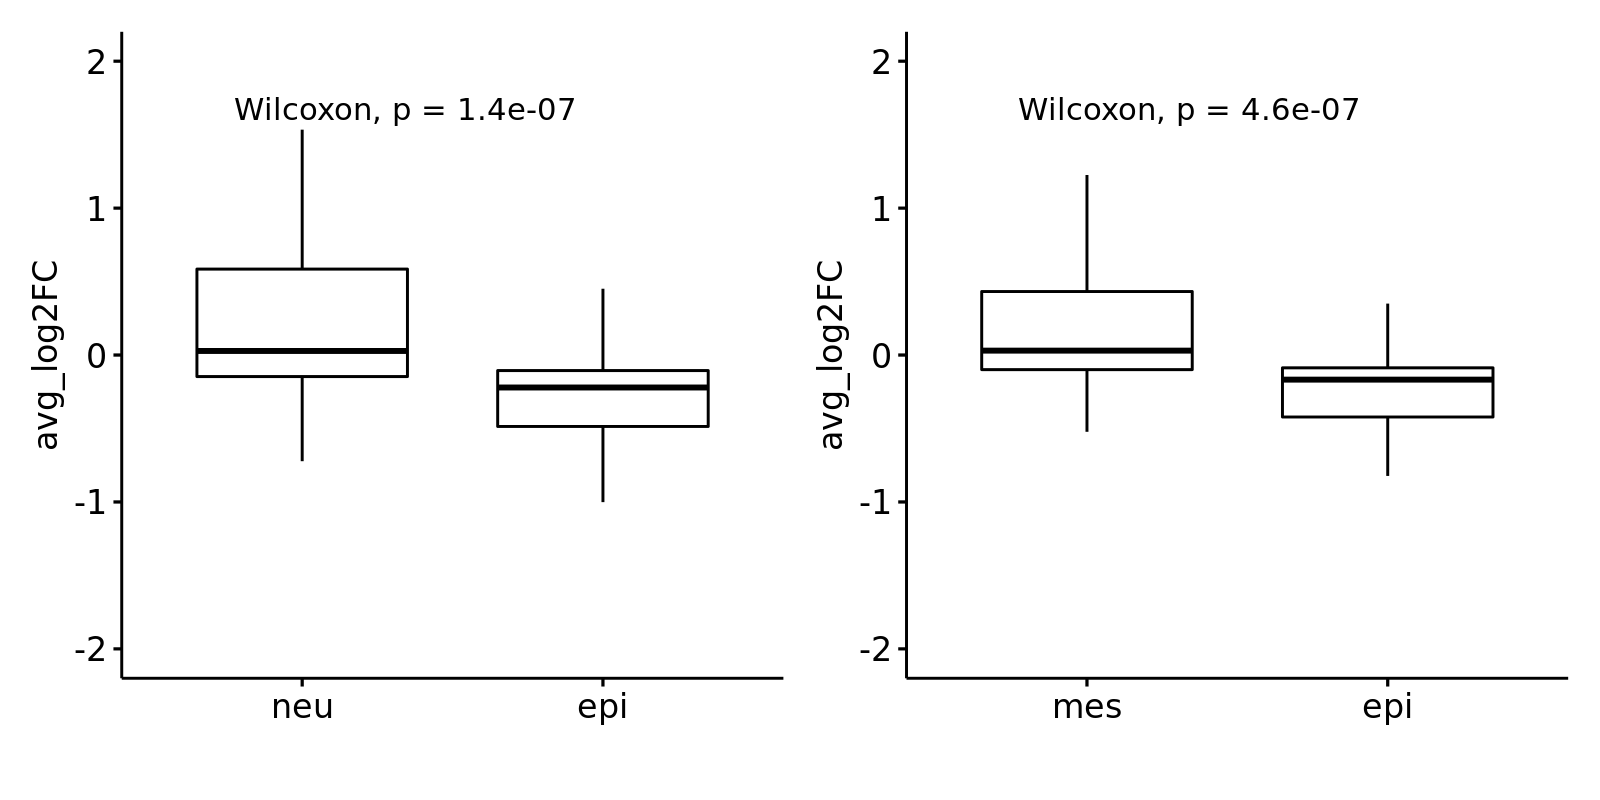

In [51]:
options(repr.plot.height=4,repr.plot.width = 8,repr.plot.res =200)
c | d